In [45]:
import rioxarray as rxr
import xarray as xr
import numpy as np
import pandas as pd
import codebase
import matplotlib.pyplot as plt

# Parameters

In [2]:
dam_name = 'glen canyon'
reproj_crs_code = 54017

# Load data

## Load reservoir shapes

In [3]:
res_shp = codebase.load_data.load_GRanD()

In [4]:
subset_gpd = codebase.area_subsets.check_for_multiple_dams(dam_name,res_shp)
subset_bbox = subset_gpd.geometry.buffer(0).bounds
subset_bbox

,minx,miny,maxx,maxy
596,-111.570835,36.937778,-111.221875,37.105153


## Load DEM data

In [5]:
dem_filepath = '/global/scratch/users/ann_scheliga/aux_dam_datasets/'
dem_filename = 'n30w120_con.tif'
DEM = codebase.load_data.load_DEM_subset_as_rxrDA(subset_bbox,dem_filepath,dem_filename)

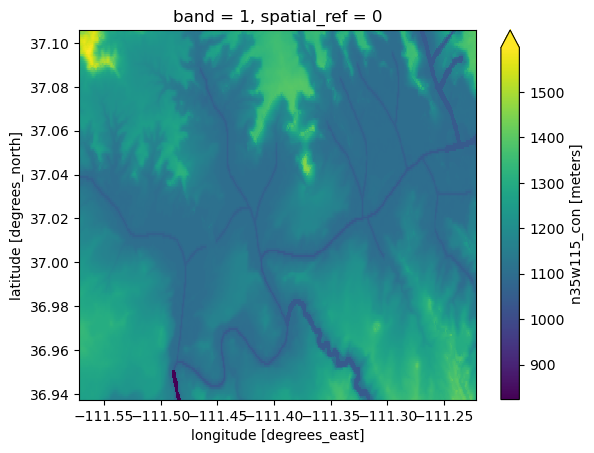

In [6]:
## Data Processing

# Adding metadata
DEM = DEM.assign_attrs(name = 'Elevation',units='meters',comments = 'referenced to WGS84 EGM96 geoid')
DEM = DEM.rename('Elevation') # name is necessary to merge into a dataset
DEM_masked = DEM.where(DEM != 32767).squeeze() # fill value = 32767
DEM_masked.plot(cbar_kwargs={'extend':'max'})

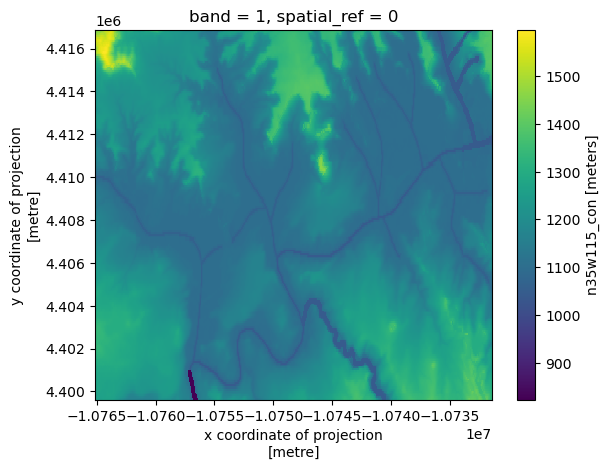

In [7]:
DEM_reproj = codebase.area_calcs.project_DA_from_crs_code(DEM_masked,reproj_crs_code)
DEM_reproj.plot()

In [8]:
DEM_reproj.shape

(212, 415)

## Load CYGNSS data

In [9]:
fw_latlon = codebase.load_data.load_CYGNSS_001_all_months(subset_bbox)
fw_binary = codebase.area_calcs.cygnss_convert_to_binary(fw_latlon)
fw_reproj = codebase.area_calcs.project_DA_from_crs_code(fw_binary,reproj_crs_code)

# Data merge
DEM and CYGNSS data into a single xr.DataSet

In [10]:
fw_res_match = fw_reproj.rio.reproject_match(DEM_reproj)

In [12]:
combo_ds = xr.merge([fw_res_match,DEM_reproj])
combo_ds

<xarray.Dataset>
Dimensions:      (time: 57, x: 415, y: 212)
Coordinates:
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9 ... 48 49 50 51 52 53 54 55 56
    spatial_ref  int64 0
  * x            (x) float64 -1.077e+07 -1.077e+07 ... -1.073e+07 -1.073e+07
  * y            (y) float64 4.417e+06 4.417e+06 4.417e+06 ... 4.4e+06 4.4e+06
    band         int64 1
Data variables:
    Watermask    (time, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    Elevation    (y, x) float32 1.445e+03 1.456e+03 ... 1.336e+03 1.32e+03
Attributes:
    units:     Binary mask of surface water
    comments:  Surface water = 1, ocean/land/no data = 0

## Groupby through xarray
Kinda confusing, trying out using pd.groupby

In [ ]:
# 1) Groupby elevation integer.
# 2) Get the fraction of each group that is inundated.
# 3) Plot of elevation int vs. fraction inundated.

In [66]:
min_elev = combo_ds['Elevation'].min()
max_elev = combo_ds['Elevation'].max()
elev_bins = np.arange(min_elev,max_elev,2)

In [36]:
test_groupby = combo_ds.groupby_bins('Elevation',bins=elev_bins).mean()
test_groupby

<xarray.Dataset>
Dimensions:         (time: 57, Elevation_bins: 7)
Coordinates:
  * time            (time) int64 0 1 2 3 4 5 6 7 8 ... 49 50 51 52 53 54 55 56
  * Elevation_bins  (Elevation_bins) object (823.0, 923.0] ... (1423.0, 1523.0]
    spatial_ref     int64 0
    band            int64 1
Data variables:
    Watermask       (Elevation_bins, time) float64 nan nan nan ... 0.0 0.0 0.0
    Elevation       (Elevation_bins) float32 nan nan ... 1.354e+03 1.473e+03
Attributes:
    units:     Binary mask of surface water
    comments:  Surface water = 1, ocean/land/no data = 0

## Groupby as pd.DataFrame (all time steps)
We'll see how this works

In [41]:
combo_df = combo_ds.to_dataframe()
combo_df.reset_index(drop=True,inplace=True)

In [67]:
elev_stats = combo_df.groupby(pd.cut(combo_df['Elevation'], elev_bins),observed=True)['Watermask'].mean()

In [79]:
elev_bin_mids = elev_stats.index.map(lambda x: x.mid)

Text(0.5, 1.0, 'Frequency of inundation of Lake Powell')

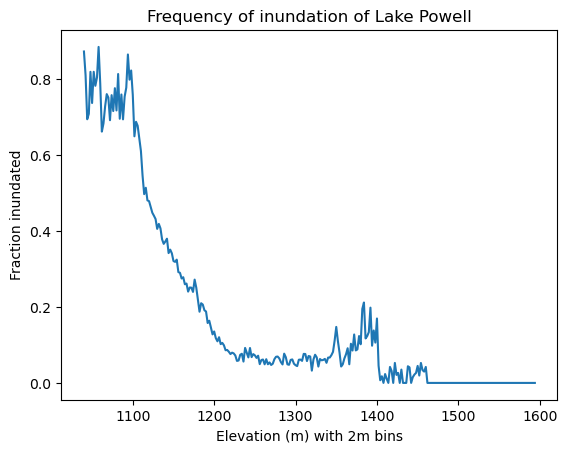

In [89]:
plt.plot(elev_bin_mids,elev_stats)
plt.ylabel('Fraction inundated')
plt.xlabel('Elevation (m) with 2m bins')
plt.title('Frequency of inundation across all time of Lake Powell')

## Groupby as pd.DataFrame (individual time steps)

In [93]:
combo_df = combo_ds.to_dataframe()
combo_df.reset_index(inplace=True)
combo_df.head(2)

,time,x,y,spatial_ref,Watermask,band,Elevation
0,0,-1.076509e+07,4.416826e+06,0,0,1,1445.0
1,0,-1.076509e+07,4.416745e+06,0,0,1,1452.0


In [97]:
elev_time_stats = combo_df.groupby(['time',pd.cut(combo_df['Elevation'], elev_bins)],observed=True)['Watermask'].mean()
elev_time_stats

time  Elevation       
0     (1039.0, 1041.0]    1.000000
      (1041.0, 1043.0]    0.924460
      (1043.0, 1045.0]    0.937500
      (1045.0, 1047.0]    0.848485
      (1047.0, 1049.0]    0.928571
                            ...   
56    (1581.0, 1583.0]    0.000000
      (1587.0, 1589.0]    0.000000
      (1589.0, 1591.0]    0.000000
      (1591.0, 1593.0]    0.000000
      (1593.0, 1595.0]    0.000000
Name: Watermask, Length: 15732, dtype: float64

In [110]:
elev_bin_mids = elev_time_stats.index.get_level_values('Elevation').map(lambda x: x.mid)
elev_bin_mids_unique = elev_bin_mids.astype(float).unique()

Text(0.5, 1.0, 'Inundation by elevation of Lake Powell at timestep = 5')

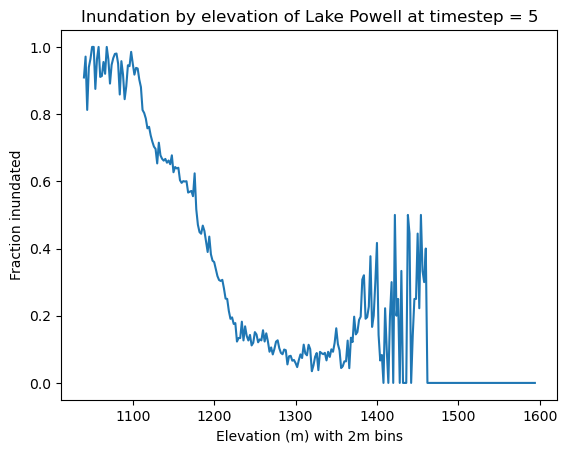

In [129]:
timestep = 5
# elev_time_stats.loc[1].plot()
plt.plot(elev_bin_mids_unique,elev_time_stats.loc[timestep])
plt.ylabel('Fraction inundated')
plt.xlabel('Elevation (m) with 2m bins')
plt.title('Inundation by elevation of Lake Powell at timestep = '+str(timestep))